In [1]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import joblib


import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression



from utils.load_data import load_data_train, load_data_test, load_data_val

from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,recall_score,balanced_accuracy_score,classification_report,ConfusionMatrixDisplay

from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import shap
from sklearn.model_selection import train_test_split

In [2]:
X_train,y_train = load_data_train()

X_test,y_test =load_data_test()

In [3]:
X_val,y_val = load_data_val()

In [4]:
models_folder = "trained_models"
subset_folder = f"{models_folder}/shortlisted_basemodels"
# get the list of models in the subset folder
model_files = [f for f in os.listdir(subset_folder) if f.endswith('.joblib')]

loaded_models = [joblib.load(f"{subset_folder}/{f}") for f in model_files]

# List to store predictions from the base models on the holdout set
base_predictions = []

models = []
for model_file in model_files:
    model = joblib.load(f"{subset_folder}/{model_file}")
    models.append(model)
    holdout_prediction = model.predict(X_val)
    base_predictions.append(holdout_prediction)

# Convert the list of predictions to a 2D array
base_predictions = np.column_stack(base_predictions)

# Train a meta-model on the base predictions and test target values
meta_model = LogisticRegression()
meta_model.fit(np.array(base_predictions), y_val)
# print(base_predictions.shape,y_val.shape)

# final_predictions = meta_model.predict(np.array([model.predict(new_data) for model in base_models]).T)
# Use the base models to make predictions on the test set
base_predictions_test = []
for model_file in model_files:
    model = joblib.load(f"{subset_folder}/{model_file}")
    models.append(model)
    test_prediction = np.array([model.predict(X_test)])
    
    base_predictions_test.append(test_prediction)

    # base_predictions_test =np.array(base_predictions_test).T


# Convert the list of test predictions to a 2D array
base_predictions_test = np.column_stack(base_predictions_test)
base_predictions_test = base_predictions_test.reshape(-1, len(model_files))


# Use the meta-model to make a final prediction on the test set
final_prediction = meta_model.predict(base_predictions_test)




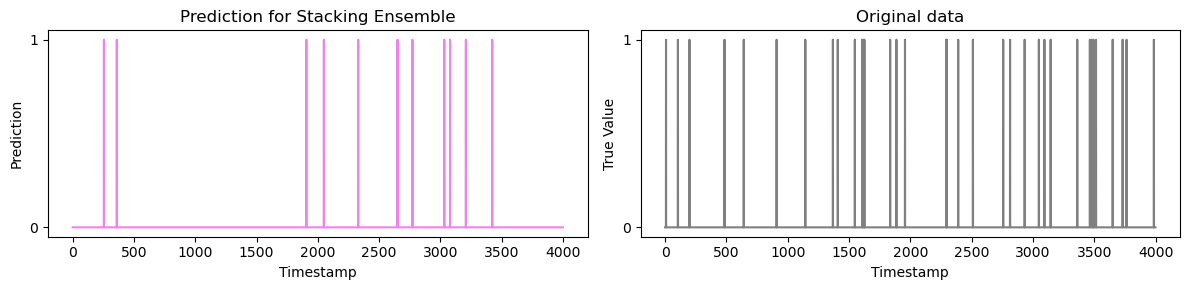

<Figure size 1100x300 with 0 Axes>

In [14]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = (11,3)

# First plot
plt.subplot(1,2,1)
plt.title("Prediction for Stacking Ensemble")
plt.plot(np.arange(len(final_prediction[19000:23000])),final_prediction[19000:23000],color="violet")
plt.xlabel("Timestamp")
plt.ylabel("Prediction")
plt.yticks([0.0, 1.0])

# Second plot
plt.subplot(1,2,2)
plt.title("Original data")
plt.plot(np.arange(len(y_test[19000:23000])),y_test[19000:23000],color="grey")
plt.xlabel("Timestamp")
plt.ylabel("True Value")
plt.yticks([0.0, 1.0])

plt.tight_layout()
plt.show()
plt.savefig('Stacking_ensemble.png')

In [6]:

base_model_weights = meta_model.coef_[0]
print("Base model weights:", base_model_weights)



Base model weights: [ 0.93238609 -0.66298281  2.15797787 -0.04853033  1.45770897  1.75341625
  0.48197992]


In [7]:
models_folder = "trained_models"
subset_folder = f"{models_folder}/stack_basemodels_fin"
# get the list of models in the subset folder
model_files = [f for f in os.listdir(subset_folder) if f.endswith('.joblib')]

loaded_models = [joblib.load(f"{subset_folder}/{f}") for f in model_files]

# List to store predictions from the base models on the holdout set
base_predictions = []

models = []
for model_file in model_files:
    model = joblib.load(f"{subset_folder}/{model_file}")
    models.append(model)
    holdout_prediction = model.predict(X_val)
    base_predictions.append(holdout_prediction)

# Convert the list of predictions to a 2D array
base_predictions = np.column_stack(base_predictions)

# Train a meta-model on the base predictions and test target values
meta_model = LogisticRegression()
meta_model.fit(np.array(base_predictions), y_val)
# print(base_predictions.shape,y_val.shape)

# final_predictions = meta_model.predict(np.array([model.predict(new_data) for model in base_models]).T)
# Use the base models to make predictions on the test set
base_predictions_test = []
for model_file in model_files:
    model = joblib.load(f"{subset_folder}/{model_file}")
    models.append(model)
    test_prediction = np.array([model.predict(X_test)])
    
    base_predictions_test.append(test_prediction)

    # base_predictions_test =np.array(base_predictions_test).T


# Convert the list of test predictions to a 2D array
base_predictions_test = np.column_stack(base_predictions_test)
base_predictions_test = base_predictions_test.reshape(-1, len(model_files))


# Use the meta-model to make a final prediction on the test set
final_prediction = meta_model.predict(base_predictions_test)


<Figure size 1100x300 with 0 Axes>

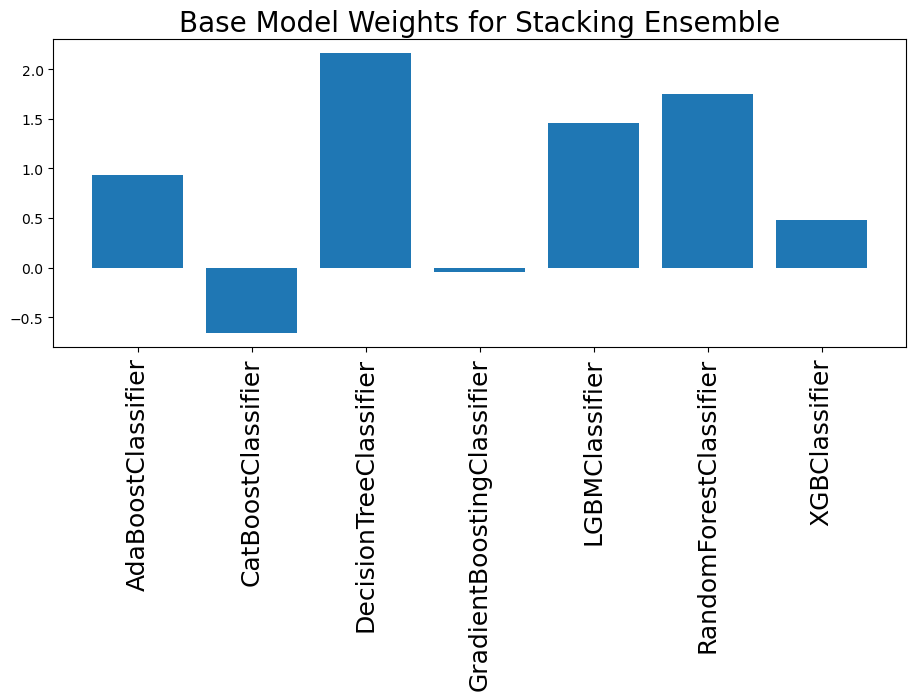

In [8]:

# Define the folder where the base models are saved
models_folder = "trained_models"
subset_folder = f"{models_folder}/shortlisted_basemodels"

# Get the list of file names in the folder
file_names = os.listdir(subset_folder)

# Extract the names of the models from the file names
base_model_names = [os.path.splitext(file_name)[0] for file_name in file_names]

fig = plt.figure()
plt.rcParams["figure.figsize"] = (11,4)
# Plot the weights of the base models
fig, ax = plt.subplots()
ax.bar(range(len(base_model_weights)), base_model_weights)
ax.set_xticks(range(len(base_model_names)))
ax.set_xticklabels(base_model_names, rotation=90,fontsize=18)
ax.set_title(("Base Model Weights for Stacking Ensemble"),fontsize=20)
plt.show()


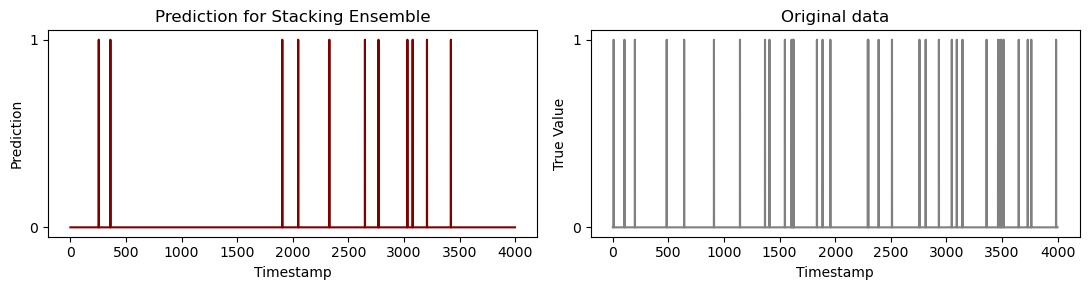

<Figure size 1100x300 with 0 Axes>

In [15]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = (11,3)

# First plot
plt.subplot(1,2,1)
plt.title("Prediction for Stacking Ensemble")
plt.plot(np.arange(len(final_prediction[19000:23000])),final_prediction[19000:23000],color="maroon")
plt.xlabel("Timestamp")
plt.ylabel("Prediction")
plt.yticks([0.0, 1.0])

# Second plot
plt.subplot(1,2,2)
plt.title("Original data")
plt.plot(np.arange(len(y_test[19000:23000])),y_test[19000:23000],color="grey")
plt.xlabel("Timestamp")
plt.ylabel("True Value")
plt.yticks([0.0, 1.0])

plt.tight_layout()
plt.show()
plt.savefig('Stacking_ensemble.png')

In [10]:
base_model_weights = meta_model.coef_[0]
print("Base model weights:", base_model_weights)

Base model weights: [0.87084494 2.16314117 0.84148359 1.74576437 0.45189524]


<Figure size 1200x300 with 0 Axes>

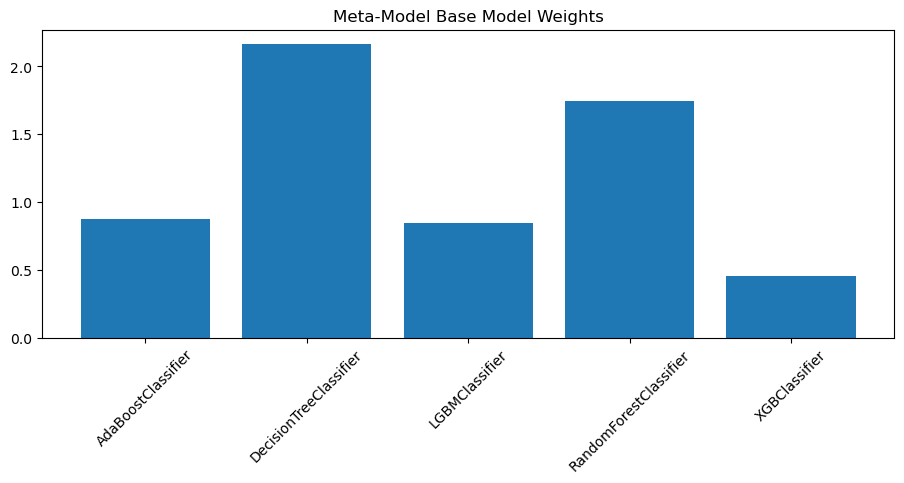

In [11]:

# Define the folder where the base models are saved
models_folder = "trained_models"
subset_folder = f"{models_folder}/stack_basemodels_fin"

# Get the list of file names in the folder
file_names = os.listdir(subset_folder)

# Extract the names of the models from the file names
base_model_names = [os.path.splitext(file_name)[0] for file_name in file_names]

fig = plt.figure()
plt.rcParams["figure.figsize"] = (11,4)
# Plot the weights of the base models
fig, ax = plt.subplots()
ax.bar(range(len(base_model_weights)), base_model_weights)
ax.set_xticks(range(len(base_model_names)))
ax.set_xticklabels(base_model_names, rotation=45)
ax.set_title("Meta-Model Base Model Weights")
plt.show()


76.0
50.0
              precision    recall  f1-score   support

         0.0       0.81      0.91      0.86   1560065
         1.0       0.20      0.10      0.13    363663

    accuracy                           0.76   1923728
   macro avg       0.51      0.50      0.49   1923728
weighted avg       0.70      0.76      0.72   1923728



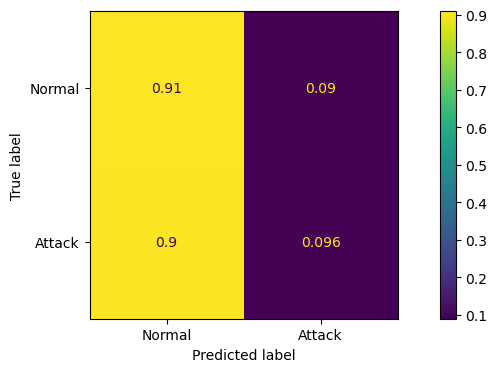

In [12]:
model_cm =confusion_matrix(y_test, final_prediction,normalize='true')
print(round(accuracy_score(y_test, final_prediction),2)*100)
y_acc = accuracy_score(y_test, final_prediction)
y_f1score = f1_score(y_test, final_prediction)
y_recall = recall_score(y_test, final_prediction)
y_bal = balanced_accuracy_score(y_test, final_prediction)
print(round(balanced_accuracy_score(y_test, final_prediction),2)*100)
print(classification_report(y_test, final_prediction))
disp = ConfusionMatrixDisplay(confusion_matrix=model_cm, display_labels = ["Normal","Attack"])
disp.plot()
# plt.savefig(f'{type(model).__name__}.png')